# Tennis with MADDPG

In this project we have created two tennis-playing agents that are trained via Multi-Agent Deep Deterministic Policy (MADDPG). The implementation is derived from the solution to a previous Udacity Deep Reinforcement Learning Nanodegree exercise in which a MADDPG is used to train agents to play the Physical Deception problem. See https://arxiv.org/pdf/1706.02275.pdf for the paper introducing MADDPG.

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

In this project the agent's learning algorithm is Multi-Agent Deep Deterministic Policy (MADDPG). The MADDPG meta-agent manages multiple DDPG agents, each with two actor networks (local and target) and two critic networks (local and target). The full observation set (plus actions from all agents) is provided to all critic networks for training, but each agent's actor receives only the observations pertaining to that agent.

In MADDPG, training is performed by running episodes and storing each step in a replay buffer. The training then iterates over batches of samples randomly drawn from the replay buffer, optimizing both actor and critic networks. 

A simple neural network architecture is used for both actors and critics. For the actors, the NNs consist of:
- two fully-connected hidden layers, of 256 and 128 units, with ReLU activation and dropout
- a fully-connected output layer of size corresponding to the number of actions (in this case, two: movement and jumping) with tanh activation which limits its output to the action space

For the critics, the NNs consist of:
- two fully-connected hidden layers, of 256 and 512 units, with ReLU activation and dropout
- a fully-connected output layer with a single unit (and no activation function) estimating the Q of the input values

The weights for both actor and critic networks (local copy) are updated using Adam optimizers, and the target instances of each are updated from the local copies via soft updates.

The hyperparameter values used were:

```python
hidden_in_actor = 256
hidden_out_actor = 128
hidden_in_critic = 256
hidden_out_critic = 512
lr_actor = 1e-5
lr_critic = 1e-5
dropout = 0.1
ou_sigma = 0.3

batchsize = 512
episode_length = 512
update_step_interval = 1
update_iterations = 5
discount_factor = 0.98
tau = 1e-2
initial_noise_scale = 3.0
min_noise_scale = 0.1
episode_noise_end = 300
replay_buffer_len = 1_000_000
```

The most challenging part of the project was getting the update cycle correct.  The final pseudocode follows.

```python
# At each update, run for each agent:

# -- UPDATE THE CRITIC NETWORK --
# for each replay buffer sample (vectorized across the batch):
#   for each agent:
#     use target actor NN and agent's next_obs to get agent's target_actions
#   concat next_obs_full and all agent target_actions as critic input
#   use this critic input with agent's target critic to get Qnext
#   y = sample_reward[agent_number] + (discount * Qnext)
#
#   concat obs_full and all agent sample actions as critic input
#   use this critic input with agent's local critic to get Q
#   optimize MSE loss between Q and y, updating agent's local critic

# -- UPDATE THE AGENT'S ACTOR NETWORK USING POLICY GRADIENT --
# for each replay buffer sample (vectorized across the batch):
#   use local actor NN and agent's obs to get this agent's new actions
#   concat obs_full and all agent actions as critic input (for this
#     agent, replace sampled actions with the new actions)
#   use this critic input with agent's local critic to get Q
#   negatize Q to use as loss function to optimizer of agent's local actor NN
```

This update is repeated 5 times at each step of the episode.

## Code Structure

### networkforall.py

`networkforall.py` has the PyTorch deep neural network model that implements both the actor and critic neural networks.

### ddpg_agent.py

`ddpg_agent.py` provides the per-agent logic around the neural network. It creates four instances of the NN from networkforall.py: two actor networks (local and target), and two critic networks (local and target). Its interface methods include:
- act(): given observations for this agent, return the selected action based on the local policy, optionally with OU noise added
- target_act(): given observations for this agent, return the selected action based on the target policy, optionally with OU noise added

### maddpg_agent.py

`maddpg_agent.py`'s MADDPG_Agent class manages the MADDPG algorithm. It keeps an instance of DDPGAgent for each agent. Methods include
- act(): return the results of each agent's act()
- target_act(): return the results of each agent's target_act
- update(): update actor and critic networks of all agents (local networks, not target networks)
- update_targets(): soft-update actor and critic target networks of all agents

### maddpg_train.py

`maddpg_train.py` manages the MADDPG training. It runs the desired number of training episodes (stopping early if the goal is reached), as follows:

Execute an entire episode, and at each step:
- Store the step in the replay buffer
- Draw a random sample from the replay buffer
- Update the MADDPG agent

### run_random.py, run_test.py

Although the primary interactive method for working with this algorithm is the `Tennis.ipynb` notebook, `run_random.py` and run_test.py allows command-line based runs of the algorithm, either using using randomly chosen hyperparameters or a specific set of hyperparameters.

## Sample Plot of Training Rewards

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from maddpg_train import GOAL_WINDOW_LEN
with open('score_history.txt') as fp:
    mean_rewards = [float(x) for x in fp.read().splitlines()]
print('Environment solved in {:d} episodes!'.format(len(mean_rewards) - GOAL_WINDOW_LEN))

Environment solved in 2122 episodes!


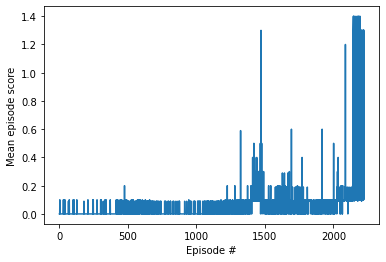

In [3]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(mean_rewards)), mean_rewards)
plt.ylabel('Mean episode score')
plt.xlabel('Episode #')
plt.show()

## Ideas for Future Work

Other areas in which to search for improvement include:
- better optimizing the hyperparameters and neural network architecture
- prioritized experience replay in order to learn more efficiently
- parameter noise (https://openai.com/blog/better-exploration-with-parameter-noise/) sounds like an interesting topic to investigate
- the MADDPG paper mentions the use of entropy regularization which could be explored
- the MADDPG paper describes an option for policy ensembles in which agents have multiple subpolicies to help with environment non-stationarity; the paper suggests this is most helpful in competitive environments, which this is not, but it would still be interesting to try

## Helpful Resources

In addition to the Udacity coursework and help forum, and the [MADDPG paper from Lowe et. al.](https://arxiv.org/abs/1706.02275), the blog post at https://towardsdatascience.com/training-two-agents-to-play-tennis-8285ebfaec5f was helpful while trying to identify issues with my project after it was written but before it was working. In addition, during that time it was also helpful to review the github repo of the blog post's author at https://github.com/tommytracey/DeepRL-P3-Collaboration-Competition in order to gain insights into how my project was going astray as well as to better understand some pytorch usage.